In [1]:
import tensorflow as tf
import pandas as pd
import string
import emoji
import re
import nltk
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.metrics import edit_distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from textattack.augmentation import EmbeddingAugmenter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import gensim
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

c:\Users\yijin\anaconda3\envs\thesistf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
raw_data = pd.read_csv("Report Dataset.csv", on_bad_lines='skip', encoding='latin1')
raw_data = raw_data.drop(columns = 'techreport')

In [7]:
raw_data.sample(10)

,conclusion,Abnormal
3034,The EEG is within normal limits.\n(15/05/2006),0.0
4990,"Abnormal EEG because, \n1) Slow background alp...",1.0
2788,The EEG showed generalised attenuation persist...,1.0
10796,Abnormal EEG :\n1. Diffuse delta slow waves du...,NaN
12014,Abnormal awake and sleep EEG showing.\n1. Asym...,NaN
2955,"1) Temporal spikes in sleep, synchronous with ...",1.0
7417,EEG shows bilateral periodic lateralised epile...,NaN
1051,The EEG does not show NCSE. There was evidence...,1.0
334,Abnormal EEG due to bifrontal slowing (R)>(L)....,1.0
13649,Normal background with posterior dominant rhyt...,NaN


We can see that there are some data with labelled and some unlabelled. This dataset contains 5000 labelled data and the remaining are unlabelled.

In [8]:
labelled_data = raw_data[~raw_data['Abnormal'].isna()]
unlabelled_data = raw_data[raw_data['Abnormal'].isna()]

In [9]:
labelled_data.sample(10)

,conclusion,Abnormal
4331,This is abnormal EEG because of background dif...,1.0
3233,1) EEG is normal.\n2) No epileptiform discharg...,0.0
395,Mildly abnormal EEG because of (L) fronto-temp...,1.0
3641,"1) Bilateral periodic small spikes, no after, ...",1.0
153,Abnormal EEG due to bifrontal and (L) centro p...,1.0
909,Abnormal EEG because of (R) temporal sharp wav...,1.0
3695,"1) Diffuse slow and attenuated background, not...",1.0
3337,"1) The (L) hemisphere is attenuated, more in s...",1.0
976,Fairly frequent episodes of spike/ sharp waves...,1.0
3205,"The EEG is mildly attenuated with periodic, lo...",1.0


In [10]:
unlabelled_data.sample(10)

,conclusion,Abnormal
11505,Normal awake and sleep EEG.,NaN
5914,Abnormal EEG because of bilateral independent ...,NaN
7193,The EEG was normal.,NaN
10864,Abnormal EEG because of:\n1. slow backgrounds ...,NaN
6973,The EEG was abnormal because of diffuse slow w...,NaN
10056,Frequent intermittent bilateral independent an...,NaN
6270,The EEG within normal limits.\n(12/02/2009),NaN
13459,Follow up EEG: Less frequent sharp over (R ) a...,NaN
6368,Diffuse slow background consistent with severe...,NaN
7134,The EEG shows a markedly attenuated recording ...,NaN


In [11]:
print(f"We have {len(labelled_data)} of labelled data and {len(unlabelled_data)} of unlabelled data.")

We have 5000 of labelled data and 9902 of unlabelled data.


In [12]:
labelled_data['Abnormal'].value_counts()

Abnormal
1.0    3376
0.0    1624
Name: count, dtype: int64

<Axes: xlabel='Abnormal'>

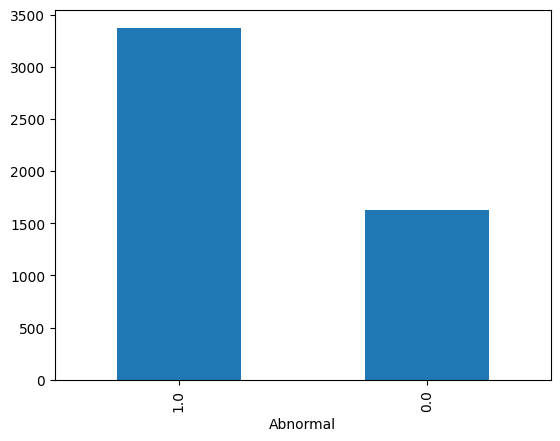

In [13]:
labelled_data.Abnormal.value_counts()[labelled_data.Abnormal.unique()].plot(kind='bar')

We can see that the data is clearly imbalance. This might affect the trainng process. Therefore, an experiment is conducted to compare performance of imbalance data and balance data (through data augmentation).

In [14]:
# save dataframe to csv
labelled_data.to_csv('labelled data.csv')
unlabelled_data.to_csv("unlabelled_data.csv")

#### Preprocessing Function

In [15]:
class AntonymReplacer(object):

    def replace(self, word, pos=None):
        
        antonyms = set()

        for syn in wordnet.synsets(word, pos=pos):
            for lemma in syn.lemmas():
                for antonym in lemma.antonyms():
                    antonyms.add(antonym.name())
        
        if len(antonyms) == 1:
            return antonyms.pop()
        else:
            return None
    
    def replace_negations(self, sent):

        i, l = 0, len(sent)
        words = []

        while i < l:

            word = sent[i]
            if word == 'not' and i+1 < l:
                ant = self.replace(sent[i+1])

                if ant:
                    words.append(ant)
                    i += 2
                    continue
                
            words.append(word)
            i += 1
        
        return words

In [16]:
# Text preprocessing function

stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):

    # Generate list of words in the report
    text = re.sub(r'https?://\S+|www\.\S+|@\w+|#\w+', '', text)

    # Remove number
    text = re.sub(r'\d+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Convert emoji to text
    text = emoji.demojize(text)

    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)

    # Tokenize text
    text = word_tokenize(text)

    # Remove empty and non-alphabetical tokens and stopwords
    text = [t for t in text if t.isalpha() and t not in stopwords]

    # Replace negation token
    replacer = AntonymReplacer()
    text = replacer.replace_negations(text)

    # Lemmatize text
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]

    return text

In [17]:
print(labelled_data['conclusion'].iloc[2])
print(preprocess(labelled_data['conclusion'].iloc[2]))

The EEG revealed on attenuated (L) hemispheric activity with (R) fronto-temporal discharges. There were perodic of attenuation of (R) sided occuring spontaneously. The EEG shows with NCSE with (L) hemisphere structural defect or subdural haematoma. 
(20/01/2004)
['eeg', 'revealed', 'attenuated', 'l', 'hemispheric', 'activity', 'r', 'frontotemporal', 'discharge', 'perodic', 'attenuation', 'r', 'sided', 'occuring', 'spontaneously', 'eeg', 'show', 'ncse', 'l', 'hemisphere', 'structural', 'defect', 'subdural', 'haematoma']


### Text Augmentation Function

In [18]:
def data_augmentation(data, target, textattack_augmenter):

    class_counts = {}
    for label in target:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    # Find minority class
    minority_class = min(class_counts, key=class_counts.get)
    
    aug_data = []
    aug_label = []

    for text, label in zip(data, target):

        if label != minority_class:
            aug_data.append(text)
            aug_label.append(label)
            continue

        aug_lst = textattack_augmenter.augment(text)
        aug_data.append(text)
        aug_label.append(label)

        aug_data.extend(aug_lst)
        aug_label.extend([label] * len(aug_lst))

    return aug_data, aug_label

In [18]:
SEED = 4000
X_train, X_test, y_train, y_test = train_test_split(labelled_data.conclusion, labelled_data.Abnormal, test_size = 0.1, random_state = SEED, shuffle=True)

In [19]:
X_train.head()

3596                         EEG is normal.\n(21/11/2006)
3594    1) Diffuse delta wave, higher amplitude in the...
4192    The EEG showed generalised attenuation with as...
3255    This EEG was within normal limits. No focal or...
3570                         EEG is normal.\n(08/11/2006)
Name: conclusion, dtype: object

In [20]:
embed_aug = EmbeddingAugmenter(pct_words_to_swap=0.1, transformations_per_example=1)
aug_data, aug_label = data_augmentation(X_train, y_train, embed_aug)

In [21]:
dict = {'conclusion': aug_data, 'Abnormal': aug_label} 
balanced_data = pd.DataFrame(dict)

In [22]:
balanced_data.sample(10)

,conclusion,Abnormal
1208,"Less discharges, which consist of isolated spi...",1.0
369,The EEG showed a rhythmic frontal delta range ...,1.0
1973,Indication: Focal seizure previous meningioma ...,1.0
3029,This EEG is within normal limits.\n(25/08/2006),0.0
5931,The EEG is suggestive of diffuse cortical dysf...,1.0
5283,Normal EEG.\n(23/09/2003),0.0
3518,This is a normal EEG.\n(15/06/2004),0.0
1338,This EEG is within normal bounds.\n(14/05/2007),0.0
2311,"1) Background is diffusely slow 5-7 Hz, not re...",1.0
3175,EEG is customary.\n(24/08/2006),0.0


In [23]:
balanced_data['Abnormal'].value_counts()

Abnormal
1.0    3052
0.0    2896
Name: count, dtype: int64

<Axes: xlabel='Abnormal'>

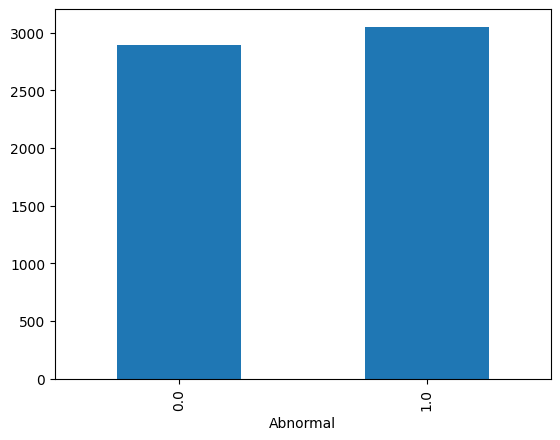

In [24]:
balanced_data.Abnormal.value_counts()[balanced_data.Abnormal.unique()].plot(kind='bar')

In [20]:
# save dataframe to csv
balanced_data.to_csv("balanced data.csv")

### SVM with TdidfVectorizer

##### Train on Imbalanced Data

In [19]:
# Initialize tfidf vectorizer
vec = TfidfVectorizer(
    analyzer = preprocess,
    min_df = 2,
    max_df = 0.9,
    sublinear_tf = True,
    use_idf = True
)

tfidf_model = vec.fit(labelled_data['conclusion'])
train_vec = vec.transform(labelled_data['conclusion'])

In [20]:
# Save trained vectorizer
vectorizer_pth = 'tfidf_vectorizer_imbalanced.sav'
pickle.dump(tfidf_model, open(vectorizer_pth, 'wb'))

In [21]:
SEED = 4000
X_train, X_test, y_train, y_test = train_test_split(train_vec, labelled_data.Abnormal, test_size = 0.1, random_state = SEED)

In [22]:
# display the size of data
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (4500, 1088)
X_test shape: (500, 1088)
y_train shape: (4500,)
y_test shape: (500,)


In [23]:
# Create a svm classifier
tfidf_svm = SVC(random_state=39)
tfidf_svm.fit(X_train, y_train.values.ravel())

SVC(random_state=39)

In [24]:
# evaluate trained SVM on test data
print('Result of SVM with TFIDF Vectorizer\n')
predictions = tfidf_svm.predict(X_test)
print(classification_report(predictions, y_test))
print('\n')
print('Confusion matrix: \n', confusion_matrix(predictions, y_test))
print('\n')
print('Accuracy score: ', accuracy_score(predictions, y_test))

Result of SVM with TFIDF Vectorizer

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       166
         1.0       0.99      0.96      0.97       334

    accuracy                           0.96       500
   macro avg       0.95      0.97      0.96       500
weighted avg       0.97      0.96      0.96       500



Confusion matrix: 
 [[162   4]
 [ 14 320]]


Accuracy score:  0.964


In [25]:
# save model
with open('tfidf_svm_imbalanced', 'wb') as f:
    pickle.dump(tfidf_svm, f)

##### Train on Balanced Data

In [43]:
df = pd.read_csv("labelled data.csv")
df.sample(10)

,Unnamed: 0,conclusion,Abnormal
2406,2406,Indication: (R) sided neglect.\nFindings: Asym...,1.0
4053,4053,The EEG is within normal limits.\n(11/04/2007),0.0
4750,4750,"Diffuse slow waves, predominant delta range, c...",1.0
4139,4139,Moderate abnormal EEG because of very frequent...,1.0
2739,2739,This EEG is normal.\n(25/01/2006),0.0
1051,1051,The EEG does not show NCSE. There was evidence...,1.0
1191,1191,The EEG is within normal limits. \n(24/07/2004),0.0
3827,3827,"1) Background is slow, 6-7 Hz.\n2) Bifrontal d...",1.0
2645,2645,The EEG is within normal limits.\n(21/12/2005),0.0
3316,3316,"1) Diffuse polymorphic slow waves, 2-4 Hz not ...",1.0


In [44]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.sample(10)

,conclusion,Abnormal
4513,1) Background is attenuated in the (L) hemisph...,1.0
234,The EEG shows an absence of alpha activity. In...,1.0
782,The EEG is within normal limits. \n(13/03/2004),0.0
4494,1) Background is slow in the (R). Consistent w...,1.0
2855,The EEG is within normal limits.\n(15/03/2006),0.0
4620,EEG is normal.\n(03/10/2007),0.0
1484,The EEG reveal a slowing background rhythmic r...,1.0
1979,The EEG is within normal limits.\n(06/01/2005),0.0
4102,"1) Background is diffusely slow, 7-8 Hz.\n2) N...",1.0
57,The EEG has improved compared to the one in 15...,1.0


In [45]:
SEED = 4000
X_train, X_test, y_train, y_test = train_test_split(df.conclusion, df.Abnormal, test_size = 0.1, random_state = SEED, shuffle=True)

In [46]:
embed_aug = EmbeddingAugmenter(pct_words_to_swap=0.1, transformations_per_example=1)
aug_data, aug_label = data_augmentation(X_train, y_train, embed_aug)

In [47]:
X_train, y_train = aug_data, aug_label

In [52]:
train_data = pd.DataFrame(
    {'conclusion': X_train,
     'Abnormal': y_train
    })

In [53]:
train_data.sample(10)

,conclusion,Abnormal
175,The EEG show an absence of reactive biposteri...,1.0
3574,1) Background was normal.\n2) Periodic sharp a...,0.0
1700,The EEG is probable within normal limits for a...,0.0
3364,The EEG was within normal restricted.\n(26/07/...,0.0
4413,The EEG is within normal limits.,0.0
1866,"1) Background is slow, 6-7 Hz \n2) Saline indu...",1.0
4087,Mildly abnormal.\n1) Normal background.\n2) Bu...,1.0
4208,"Diffuse slow wave, 5-6 Hz with one small ampli...",1.0
4710,The EEG was within normal restricting. \n(14/1...,0.0
1391,The EEG suggestive of diffuse cortical dysfunc...,1.0


<Axes: xlabel='Abnormal'>

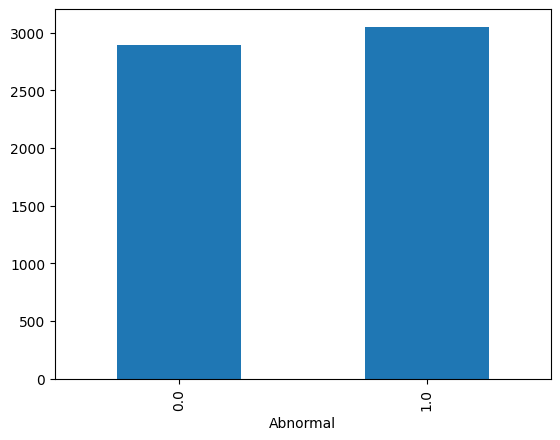

In [54]:
train_data.Abnormal.value_counts()[train_data.Abnormal.unique()].plot(kind='bar')

In [55]:
test_data = pd.DataFrame(
    {'conclusion': X_test,
     'Abnormal': y_test
    })

whole_data = pd.concat([train_data, test_data])

In [56]:
whole_data.sample(10)

,conclusion,Abnormal
4138,Mildly abnormal EEG because of slightly slow b...,1.0
2808,EEG is routine.\n(29/03/2007),0.0
887,Abnormal EEG because of generalized spike disc...,1.0
5248,EEG is usual.\n(15/01/2008),0.0
269,"1) There was diffuse delta waves, higher ampli...",1.0
3802,The EEG shows absence of reactive alpha activi...,1.0
3455,The EEG revealed a slower background for age w...,1.0
803,No focal or epileptiform features noted. An ex...,0.0
3711,Ordinary study.\n(06/08/2004),0.0
1802,"Diffuse asymmetrical slow waves, 1-2 Hz higher...",1.0


In [57]:
# Initialize tfidf vectorizer
vec = TfidfVectorizer(
    analyzer = preprocess,
    min_df = 2,
    max_df = 0.9,
    sublinear_tf = True,
    use_idf = True
)

tfidf_model = vec.fit(whole_data['conclusion'])
train_vec = vec.transform(whole_data['conclusion'])

In [58]:
# Save trained vectorizer
vectorizer_pth = 'tfidf_vectorizer_balanced.sav'
pickle.dump(tfidf_model, open(vectorizer_pth, 'wb'))

In [64]:
X_train, y_train = train_data["conclusion"], train_data["Abnormal"]
X_train = vec.transform(X_train)
X_test, y_test = test_data["conclusion"], test_data["Abnormal"]
X_test = vec.transform(X_test)

In [65]:
# display the size of data
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (5948, 1237)
X_test shape: (500, 1237)
y_train shape: (5948,)
y_test shape: (500,)


In [66]:
# Create a svm classifier
tfidf_svm = SVC(random_state=39)
tfidf_svm.fit(X_train, y_train.values.ravel())

SVC(random_state=39)

In [67]:
# evaluate trained SVM on test data
print('Result of SVM with TFIDF Vectorizer\n')
predictions = tfidf_svm.predict(X_test)
print(classification_report(predictions, y_test))
print('\n')
print('Confusion matrix: \n', confusion_matrix(predictions, y_test))
print('\n')
print('Accuracy score: ', accuracy_score(predictions, y_test))

Result of SVM with TFIDF Vectorizer

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       167
         1.0       0.99      0.96      0.97       333

    accuracy                           0.97       500
   macro avg       0.96      0.97      0.96       500
weighted avg       0.97      0.97      0.97       500



Confusion matrix: 
 [[163   4]
 [ 13 320]]


Accuracy score:  0.966


We can see that the performance of SVM on balanced dataset improved, according to evaluation metrics and confusion matrix. Therefore, the rest of the process will be using balanced data.

We will save the data into csv format. Remember that it is important to save them seperately. As we can only augment train data, but not test data. Test data should be all read original data.

In [72]:
# save train data and test data seperately
train_data.to_csv('supervised_train_data.csv', index=False)
test_data.to_csv("supervised_test_data.csv", index=False)

In [83]:
whole_data.to_csv("Supervised_whole_data.csv", index=False)

#### SVM with Word2Vec

In [73]:
train_data = pd.read_csv("supervised_train_data.csv")
test_data = pd.read_csv("supervised_test_data.csv")

In [74]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [75]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yijin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"

def preprocess(text, stem=False):

    # Remove link, user, and special character
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)

    return " ".join(tokens)

In [77]:
%time
train_data.conclusion = train_data.conclusion.apply(lambda x: preprocess(x))
test_data.conclusion = test_data.conclusion.apply(lambda x: preprocess(x))

CPU times: total: 0 ns
Wall time: 0 ns


In [80]:
train_data.sample(10)

,conclusion,Abnormal
2491,indication collapse x conclusion eeg within no...,0.0
4299,eeg normal,0.0
5644,abnormal eeg intermittent l fronto temporal sl...,1.0
2426,eeg showed alpha waves hz activiti diffuse the...,1.0
1951,background normal l slower r indicative r cort...,1.0
5482,abnormal eeg diffuse irregular slow background...,1.0
4485,sleep latency reduced epoch sleep onset rem se...,1.0
610,abnormal eeg diffuse irregular slow waves seen...,1.0
2277,eeg within normal capped,0.0
3165,eeg findings consistent partial seizure disord...,1.0


In [81]:
test_data.sample(10)

,conclusion,Abnormal
214,eeg within normal limits,0.0
64,eeg background normal occasional suspicious sh...,0.0
422,diffuse slow waves hz responsive sensory stimu...,1.0
447,eeg showed absence normal background architect...,1.0
19,eeg revealed diffuse cortical dysfunction,1.0
98,eeg showed normal waking sleep background arch...,1.0
183,burst l frontal slow indicating structural def...,1.0
23,eeg shows absence alpha activities instead fre...,1.0
13,eeg showed normal sleep waking background susp...,0.0
272,abnormal eeg frequent l anterior quadrant slow...,1.0


In [82]:
# split data into train and test set
X_train, y_train = train_data['conclusion'].values, train_data['Abnormal'].values
X_test, y_test = test_data['conclusion'].values, test_data['Abnormal'].values

##### CBOW Word2Vec Model Training

In [84]:
whole_data = pd.read_csv("Supervised_whole_data.csv")
whole_data.conclusion = whole_data.conclusion.apply(lambda x: preprocess(x))

In [85]:
documents = [_text.split() for _text in whole_data.conclusion]

In [86]:
# Train CBOW Word2Vec model
w2vmodel = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8, sg=1)

In [87]:
words = w2vmodel.wv.index_to_key
vocab_size_wv = len(words)
print("Vocab size:", vocab_size_wv)

Vocab size: 473


In [88]:
w2vmodel.wv.most_similar("abnormal")

[('irregular', 0.8728219866752625),
 ('intermittent', 0.871496856212616),
 ('poorly', 0.8608562350273132),
 ('showing', 0.8555079698562622),
 ('mildly', 0.8514851331710815),
 ('continuously', 0.8511282801628113),
 ('suggesting', 0.8384247422218323),
 ('bitemporally', 0.8300043940544128),
 ('intermittently', 0.8285265564918518),
 ('moderately', 0.8255431652069092)]

In [89]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(whole_data.conclusion)

In [90]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 2237


In [91]:
SEQUENCE_LENGTH = 300
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

In [92]:
labels = balanced_data.Abnormal.unique().tolist()
labels

[0.0, 1.0]

In [93]:
encoder = LabelEncoder()
encoder.fit(balanced_data.Abnormal.tolist())

y_train = encoder.transform(y_train.tolist())
y_test = encoder.transform(y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)


y_train (5948, 1)
y_test (500, 1)


In [94]:
# Create a svm classifier
w2v_svm = SVC(random_state=39)
w2v_svm.fit(X_train, y_train)

c:\Users\yijin\anaconda3\envs\thesistf\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(random_state=39)

In [95]:
# evaluate trained SVM on test data
print('Result of SVM with Word2Vec Vectorizer\n')
predictions = w2v_svm.predict(X_test)
print(classification_report(predictions, y_test))
print('\n')
print('Confusion matrix: \n', confusion_matrix(predictions, y_test))
print('\n')
print('Accuracy score: ', accuracy_score(predictions, y_test))

Result of SVM with Word2Vec Vectorizer

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       184
           1       0.90      0.93      0.92       316

    accuracy                           0.89       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.89      0.89       500



Confusion matrix: 
 [[153  31]
 [ 23 293]]


Accuracy score:  0.892


Based on the experiment above, we found out that SVM performed better with TF-IDF when compared to Word2Vec.